#### Set up XGBoost model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors as plt_colors
from matplotlib.colors import ListedColormap
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.multiclass import OneVsRestClassifier
import pickle
import shap
import seaborn as sns

In [2]:
pb1f2_onehot_filtered = pd.read_csv("pb1-f2_onehot_filtered.csv")

In [3]:
Traits = pb1f2_onehot_filtered.iloc[:, 0]
amino_acid_matrix = pb1f2_onehot_filtered.iloc[:, 1:]
NumberOfDatapoints = amino_acid_matrix.shape[0]

y = Traits.iloc[:NumberOfDatapoints]
X = amino_acid_matrix.iloc[:NumberOfDatapoints, :]

In [4]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

# Get the unique values and their counts
train_unique_vals, train_counts = np.unique(y_train, return_counts=True)
val_unique_vals, val_counts = np.unique(y_val, return_counts=True)
test_unique_vals, test_counts = np.unique(y_test, return_counts=True)

print("Training set:")
for val, count in zip(train_unique_vals, train_counts):
    print(f"{val}: {count}")
print("Validation set:")
for val, count in zip(val_unique_vals, val_counts):
    print(f"{val}: {count}")
print("Test set:")
for val, count in zip(test_unique_vals, test_counts):
    print(f"{val}: {count}")
    
# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)


Training set:
0: 307
1: 795
2: 75
3: 26
Validation set:
0: 34
1: 89
2: 8
3: 3
Test set:
0: 38
1: 99
2: 9
3: 3


##### Make bayesian optimizaton search on model parameters

In [5]:
from skopt import BayesSearchCV

# Define the objective function
def objective(params):
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class= 4,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=42,
        **params
    )
    
    # Perform cross-validation and return the average score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return 1 - score  # Convert accuracy to a minimization problem

# Define the parameter space
param_space = {
    'max_depth': (3, 8),
    'eta': (0.05, 0.2),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 1),
    'min_child_weight': (1, 3)
}

# Initialize the Bayesian Optimization algorithm
opt = BayesSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', n_jobs=-1),
    search_spaces=param_space,
    scoring='balanced_accuracy',
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Run the optimization
opt.fit(X_train, y_train)

# Retrieve the best hyperparameters
best_params = opt.best_params_
print(best_params)

OrderedDict([('colsample_bytree', 0.9187540808794179), ('eta', 0.1660804931889286), ('gamma', 0), ('max_depth', 8), ('min_child_weight', 1), ('subsample', 0.5306499354702751)])


##### Save best parameters

In [18]:
#with open('best_params_pb1f2.pkl', 'wb') as file:
#    pickle.dump(best_params, file)

In [5]:
# To load the parameters from the file later
with open('best_params_pb1f2.pkl', 'rb') as file:
    best_params = pickle.load(file)

##### Make loop for cross-validating the model

In [6]:
# Setting up weighing
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=pb1f2_onehot_filtered['Trait_num']
)

# Set the number of folds
n_folds = 20

# Initialize lists to store accuracy and SHAP values for each fold
accuracy_list = []
shap_values_list = []
y_test_list = []
y_prob_list = []

# Initialize lists to store ROC curve data for each class
fpr_list = []
tpr_list = []
auc_list = []

# Initialize empty confusion matrix
n_classes = 4
avg_cm = np.zeros((n_classes, n_classes), dtype=float)

# Loop over the folds to train the model
for i in range(n_folds):
    print(f"Fold {i+1}/{n_folds}")
    
    # Split the data into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

    # Convert the data to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=classes_weights[y_train.index])
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set up the xgboost model
    params = {
        'objective': 'multi:softprob',
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        **best_params
        }

    # Train the model on the training set, and evaluate it on the validation set
    evals_result = {}
    model = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtrain, 'train'), (dval, 'validation')], evals_result=evals_result, verbose_eval=100, early_stopping_rounds=20)

    # Get predicted classes and their probabilities for the test set
    y_prob = model.predict(dtest)  # predicted probabilities for each class
    y_pred = np.argmax(y_prob, axis=1)  # predicted class for each sample

    # compute accuracy and log_loss
    accuracy = accuracy_score(y_test, y_pred) 
    cm = confusion_matrix(y_test, y_pred)

    # Append accuracy to the list
    accuracy_list.append(accuracy)
    
    # Compute confusion matrix and add to running total
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    avg_cm += cm_norm
    
    # Compute ROC curve for each class
    fpr_fold = {}
    tpr_fold = {}
    auc_scores_fold = {}
    for j in range(n_classes):
        fpr_fold[j], tpr_fold[j], _ = roc_curve(y_test, y_prob[:, j], pos_label=j)
        auc_scores_fold[j] = roc_auc_score(y_test == j, y_prob[:, j])
    
    fpr_list.append(fpr_fold)
    tpr_list.append(tpr_fold)
    auc_list.append(auc_scores_fold)
    
    # Extract the SHAP values for the test set in each fold
    explainer = shap.Explainer(model)
    shap_values_fold = explainer.shap_values(X_test)
    shap_values_list.append(shap_values_fold)

Fold 1/20
[0]	train-mlogloss:1.27809	validation-mlogloss:1.25495
[43]	train-mlogloss:0.58106	validation-mlogloss:0.69618
Fold 2/20
[0]	train-mlogloss:1.26780	validation-mlogloss:1.25953
[71]	train-mlogloss:0.51223	validation-mlogloss:0.75964
Fold 3/20
[0]	train-mlogloss:1.27690	validation-mlogloss:1.26874
[100]	train-mlogloss:0.50933	validation-mlogloss:0.70722
Fold 4/20
[0]	train-mlogloss:1.27721	validation-mlogloss:1.26934
[53]	train-mlogloss:0.53972	validation-mlogloss:0.77496
Fold 5/20
[0]	train-mlogloss:1.26902	validation-mlogloss:1.31277
[60]	train-mlogloss:0.55984	validation-mlogloss:0.88952
Fold 6/20
[0]	train-mlogloss:1.27646	validation-mlogloss:1.25881
[55]	train-mlogloss:0.56185	validation-mlogloss:0.80498
Fold 7/20
[0]	train-mlogloss:1.29337	validation-mlogloss:1.26218
[75]	train-mlogloss:0.54448	validation-mlogloss:0.66678
Fold 8/20
[0]	train-mlogloss:1.27785	validation-mlogloss:1.24660
[84]	train-mlogloss:0.52845	validation-mlogloss:0.69323
Fold 9/20
[0]	train-mlogloss:1.

In [7]:
# Compute the average accuracy over all folds
avg_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)
print(f"Average accuracy over {n_folds} folds: {avg_accuracy:.4f} ± {std_accuracy:.4f}")

# Divide running total by number of iterations to obtain averaged confusion matrix
avg_cm/= n_folds


Average accuracy over 20 folds: 0.7151 ± 0.0402


##### Confusion matrix and ROC curve 

PB1-F2 Averaged confusion matrix (as percentages):
0: hu-hu, 1: sw-sw, 2: hu-sw, 3: sw-hu
Predicted     0     1     2     3
True                             
0          78.6   5.0  10.1   6.3
1          11.8  74.7   5.3   8.2
2          54.4  15.0  24.4   6.1
3          31.7  43.3   8.3  16.7
Average AUC for 0: 0.9083096254148886
Average AUC for 1: 0.9014040404040404
Average AUC for 2: 0.7855158730158729
Average AUC for 3: 0.6302511415525113


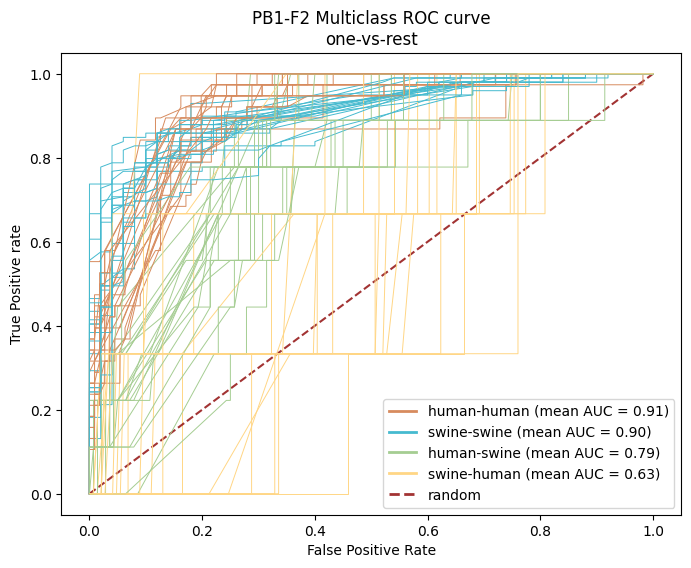

In [8]:
# Convert to percentages and round to 1 decimal place
avg_cm_percent = np.round(avg_cm * 100, decimals=1)

# convert the confusion matrix to a Pandas DataFrame
confusion_df = pd.DataFrame(avg_cm_percent)

# set the row and column names
confusion_df.index.name = 'True'
confusion_df.columns.name = 'Predicted'

# print the confusion matrix with row and column names
print("PB1-F2 Averaged confusion matrix (as percentages):\n0: hu-hu, 1: sw-sw, 2: hu-sw, 3: sw-hu")
print(confusion_df)

# multi-class classification ROC Curve 
# Initialize dictionaries to store sums and counts for each key
sums = {0: 0, 1: 0, 2: 0, 3: 0}
counts = {0: 0, 1: 0, 2: 0, 3: 0}

# Loop through the data and update the sums and counts
for entry in auc_list:
    for key, value in entry.items():
        sums[key] += value
        counts[key] += 1

# Calculate the averages
averages = {key: sums[key] / counts[key] for key in sums}

# Print the averages
for key, value in averages.items():
    print(f"Average AUC for {key}: {value}")

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plotting
count = 0
fig, ax = plt.subplots(figsize=(8, 6))
for fpr, tpr, auc_scores in zip(fpr_list, tpr_list, auc_list): 
    if count == 0:
        ax.plot(fpr[0], tpr[0], linestyle='-', linewidth=0.7, color="#D78B5E", label=f'human-human (mean AUC = {np.array(list(averages.values()))[0]:.2f})')
        ax.plot(fpr[1], tpr[1], linestyle='-', linewidth=0.7,color="#45BACF", label=f'swine-swine (mean AUC = {np.array(list(averages.values()))[1]:.2f})')
        ax.plot(fpr[2], tpr[2], linestyle='-', linewidth=0.7,color="#A5CD92", label=f'human-swine (mean AUC = {np.array(list(averages.values()))[2]:.2f})')
        ax.plot(fpr[3], tpr[3], linestyle='-', linewidth=0.7,color="#FFD685", label=f'swine-human (mean AUC = {np.array(list(averages.values()))[3]:.2f})')
        plt.plot(p_fpr, p_tpr, linestyle='--', color='darkred', alpha=0.8, label=f'random')
        count += 1
    else:
        ax.plot(fpr[0], tpr[0], linestyle='-', linewidth=0.7, color="#D78B5E")
        ax.plot(fpr[1], tpr[1], linestyle='-', linewidth=0.7, color="#45BACF")
        ax.plot(fpr[2], tpr[2], linestyle='-', linewidth=0.7, color="#A5CD92")
        ax.plot(fpr[3], tpr[3], linestyle='-', linewidth=0.7, color="#FFD685")
ax.set_title('PB1-F2 Multiclass ROC curve\none-vs-rest')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive rate')
legend = ax.legend(loc='best')
for handle in legend.legendHandles:
    handle.set_linewidth(2.0)
plt.savefig('PB1-F2_Multiclass_ROC',dpi=300);  
plt.show()

##### Avg. SHAP

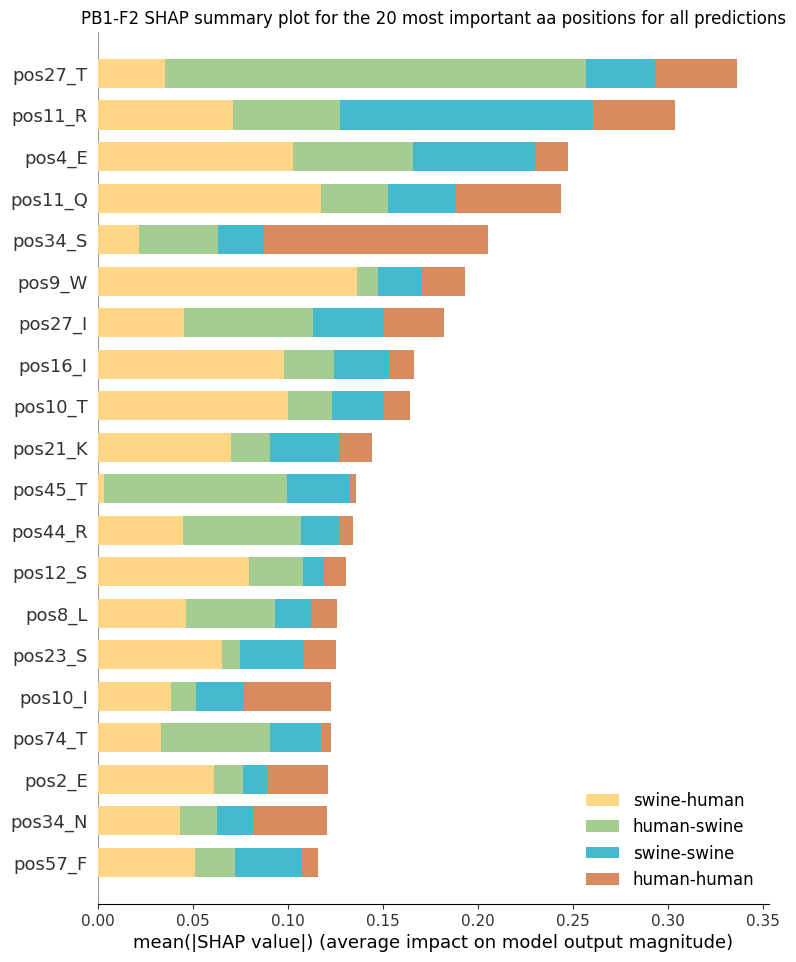

In [9]:
# Get average SHAP values from all folds
avg_shap = list(np.array(shap_values_list).mean(0))

# class names and colors
classes = ['human-human', 'swine-swine', 'human-swine', 'swine-human']
class_colors= ["#D78B5E", "#45BACF", "#A5CD92", "#FFD685"]

class_inds = np.argsort([-np.abs(avg_shap[i]).mean() for i in range(len(avg_shap))])
cmap = plt_colors.ListedColormap(np.array(class_colors)[class_inds])

shap.summary_plot(avg_shap, features = X.columns, class_names=classes, color = cmap, show=False, max_display=20)

plt.title("PB1-F2 SHAP summary plot for the 20 most important aa positions for all predictions")

# print plot to file
plt.savefig('PB1-F2_shap_summary_plot.png', dpi=300, bbox_inches='tight')

In [16]:
importance_H2H = abs(np.array(avg_shap)).mean(1)[0]
importance_S2S = abs(np.array(avg_shap)).mean(1)[1]
importance_H2S = abs(np.array(avg_shap)).mean(1)[2]
importance_S2H = abs(np.array(avg_shap)).mean(1)[3]

Present = np.zeros((np.shape(avg_shap)))
Not_Present = np.zeros((np.shape(avg_shap)))
                       
for species in range(np.shape(avg_shap)[0]):
    for datapoint in range(np.shape(avg_shap)[1]):
        for feature_num in range(np.shape(avg_shap)[2]):
            if X_test.values[datapoint][feature_num] == 0:
                Not_Present[species][datapoint][feature_num] = avg_shap[species][datapoint][feature_num]
            if X_test.values[datapoint][feature_num] == 1:
                Present[species][datapoint][feature_num] = avg_shap[species][datapoint][feature_num]
                
                
# Replace 0 values with NaN
Present[Present == 0] = np.nan
Not_Present[Not_Present == 0] = np.nan

# Take the mean along axis 1, ignoring NaN values
importance_WHY_present_H2H = np.nanmean(Present[0], axis=0)
importance_WHY_present_S2S = np.nanmean(Present[1], axis=0)
importance_WHY_present_H2S = np.nanmean(Present[2], axis=0)
importance_WHY_present_S2H = np.nanmean(Present[3], axis=0)
importance_WHY_notpresent_H2H = np.nanmean(Not_Present[0], axis=0)
importance_WHY_notpresent_S2S = np.nanmean(Not_Present[1], axis=0)
importance_WHY_notpresent_H2S = np.nanmean(Not_Present[2], axis=0)
importance_WHY_notpresent_S2H = np.nanmean(Not_Present[3], axis=0)
std_WHY_present_H2H = np.nanstd(Present[0], axis=0)
std_WHY_present_S2S = np.nanstd(Present[1], axis=0)
std_WHY_present_H2S = np.nanstd(Present[2], axis=0)
std_WHY_present_S2H = np.nanstd(Present[3], axis=0)
std_WHY_notpresent_H2H = np.nanstd(Not_Present[0], axis=0)
std_WHY_notpresent_S2S = np.nanstd(Not_Present[1], axis=0)
std_WHY_notpresent_H2S = np.nanstd(Not_Present[2], axis=0)
std_WHY_notpresent_S2H = np.nanstd(Not_Present[3], axis=0)

importance_dataframe = pd.DataFrame(np.column_stack([X.keys(), importance_H2H, importance_WHY_present_H2H, std_WHY_present_H2H, importance_WHY_notpresent_H2H, std_WHY_notpresent_H2H, importance_S2S, importance_WHY_present_S2S, std_WHY_present_S2S, importance_WHY_notpresent_S2S, std_WHY_notpresent_S2S, importance_H2S, importance_WHY_present_H2S, std_WHY_present_H2S, importance_WHY_notpresent_H2S, std_WHY_notpresent_H2S, importance_S2H, importance_WHY_present_S2H, std_WHY_present_S2H, importance_WHY_notpresent_S2H, std_WHY_notpresent_S2H]), columns=["Feature", "human_human_HOW_important", "human_human_importance_present", "human_human_std_present", "human_human_importance_not_present", "human_human_std_not_present", "swine_swine_HOW_important", "swine_swine_importance_present", "swine_swine_std_present", "swine_swine_importance_not_present", "swine_swine_std_not_present", "human_swine_HOW_important", "human_swine_importance_present", "human_swine_std_present", "human_swine_importance_not_present", "human_swine_std_not_present", "swine_human_HOW_important", "swine_human_importance_present", "swine_human_std_present", "swine_human_importance_not_present", "swine_human_std_not_present"])
importance_dataframe.head()#, importance_dataframe.values[int(np.where(X_test.keys() == 'pos47_N')[0])]
importance_H2H = abs(np.array(avg_shap)).mean(1)[0]
importance_S2S = abs(np.array(avg_shap)).mean(1)[1]
importance_H2S = abs(np.array(avg_shap)).mean(1)[2]
importance_S2H = abs(np.array(avg_shap)).mean(1)[3]

Present = np.zeros((np.shape(avg_shap)))
Not_Present = np.zeros((np.shape(avg_shap)))
                       
for species in range(np.shape(avg_shap)[0]):
    for datapoint in range(np.shape(avg_shap)[1]):
        for feature_num in range(np.shape(avg_shap)[2]):
            if X_test.values[datapoint][feature_num] == 0:
                Not_Present[species][datapoint][feature_num] = avg_shap[species][datapoint][feature_num]
            if X_test.values[datapoint][feature_num] == 1:
                Present[species][datapoint][feature_num] = avg_shap[species][datapoint][feature_num]
                
                
# Replace 0 values with NaN
Present[Present == 0] = np.nan
Not_Present[Not_Present == 0] = np.nan

# Take the mean along axis 1, ignoring NaN values
importance_WHY_present_H2H = np.nanmean(Present[0], axis=0) 
importance_WHY_present_S2S = np.nanmean(Present[1], axis=0)
importance_WHY_present_H2S = np.nanmean(Present[2], axis=0)
importance_WHY_present_S2H = np.nanmean(Present[3], axis=0)
importance_WHY_notpresent_H2H = np.nanmean(Not_Present[0], axis=0)
importance_WHY_notpresent_S2S = np.nanmean(Not_Present[1], axis=0)
importance_WHY_notpresent_H2S = np.nanmean(Not_Present[2], axis=0)
importance_WHY_notpresent_S2H = np.nanmean(Not_Present[3], axis=0)

std_WHY_present_H2H = np.nanstd(Present[0], axis=0)
std_WHY_present_S2S = np.nanstd(Present[1], axis=0)
std_WHY_present_H2S = np.nanstd(Present[2], axis=0)
std_WHY_present_S2H = np.nanstd(Present[3], axis=0)
std_WHY_notpresent_H2H = np.nanstd(Not_Present[0], axis=0)
std_WHY_notpresent_S2S = np.nanstd(Not_Present[1], axis=0)
std_WHY_notpresent_H2S = np.nanstd(Not_Present[2], axis=0)
std_WHY_notpresent_S2H = np.nanstd(Not_Present[3], axis=0)

importance_WHY_present_H2H_N = [np.count_nonzero(~np.isnan(Present[0,:,i])) for i in range(np.shape(Present)[2])]
importance_WHY_present_S2S_N = [np.count_nonzero(~np.isnan(Present[1,:,i])) for i in range(np.shape(Present)[2])]
importance_WHY_present_H2S_N = [np.count_nonzero(~np.isnan(Present[2,:,i])) for i in range(np.shape(Present)[2])]
importance_WHY_present_S2H_N = [np.count_nonzero(~np.isnan(Present[3,:,i])) for i in range(np.shape(Present)[2])]
importance_WHY_notpresent_H2H_N = [np.count_nonzero(~np.isnan(Not_Present[0,:,i])) for i in range(np.shape(Not_Present)[2])]
importance_WHY_notpresent_S2S_N = [np.count_nonzero(~np.isnan(Not_Present[1,:,i])) for i in range(np.shape(Not_Present)[2])]
importance_WHY_notpresent_H2S_N = [np.count_nonzero(~np.isnan(Not_Present[2,:,i])) for i in range(np.shape(Not_Present)[2])]
importance_WHY_notpresent_S2H_N = [np.count_nonzero(~np.isnan(Not_Present[3,:,i])) for i in range(np.shape(Not_Present)[2])]

importance_dataframe = pd.DataFrame(np.column_stack([X.keys(), 
                                                     importance_H2H, importance_WHY_present_H2H, std_WHY_present_H2H, importance_WHY_present_H2H_N, importance_WHY_notpresent_H2H, std_WHY_notpresent_H2H, importance_WHY_notpresent_H2H_N, 
                                                     importance_S2S, importance_WHY_present_S2S, std_WHY_present_S2S, importance_WHY_present_S2S_N, importance_WHY_notpresent_S2S, std_WHY_notpresent_S2S, importance_WHY_notpresent_S2S_N,
                                                     importance_H2S, importance_WHY_present_H2S, std_WHY_present_H2S, importance_WHY_present_H2S_N, importance_WHY_notpresent_H2S, std_WHY_notpresent_H2S, importance_WHY_notpresent_H2S_N, 
                                                     importance_S2H, importance_WHY_present_S2H, std_WHY_present_S2H, importance_WHY_present_S2H_N, importance_WHY_notpresent_S2H, std_WHY_notpresent_S2H, importance_WHY_notpresent_S2H_N]), 
                                    columns=["Feature", 
                                             "human_human_HOW_important", "human_human_importance_present", "human_human_std_present", "human_human_present_N", "human_human_importance_not_present", "human_human_std_not_present", "human_human_not_present_N",
                                             "swine_swine_HOW_important", "swine_swine_importance_present", "swine_swine_std_present", "swine_swine_present_N", "swine_swine_importance_not_present", "swine_swine_std_not_present", "swine_swine_not_present_N",
                                             "human_swine_HOW_important", "human_swine_importance_present", "human_swine_std_present", "human_swine_present_N", "human_swine_importance_not_present", "human_swine_std_not_present", "human_swine_not_present_N", 
                                             "swine_human_HOW_important", "swine_human_importance_present", "swine_human_std_present", "swine_human_present_N", "swine_human_importance_not_present", "swine_human_std_not_present", "swine_human_not_present_N"])
importance_dataframe.head()#, importance_dataframe.values[int(np.where(X_test.keys() == 'pos47_N')[0])]


Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Degrees of freedom <= 0 for slice.


,Feature,human_human_HOW_important,human_human_importance_present,human_human_std_present,human_human_present_N,human_human_importance_not_present,human_human_std_not_present,human_human_not_present_N,swine_swine_HOW_important,swine_swine_importance_present,...,human_swine_importance_not_present,human_swine_std_not_present,human_swine_not_present_N,swine_human_HOW_important,swine_human_importance_present,swine_human_std_present,swine_human_present_N,swine_human_importance_not_present,swine_human_std_not_present,swine_human_not_present_N
0,pos1_M,0.002816,0.000741,0.00449,147,0.007213,0.00016,2,0.0,NaN,...,0.009766,0.000643,2,0.000317,0.000134,0.00057,147,0.00022,0.000018,2
1,pos1_T,0.001019,0.001896,0.00099,2,-0.000021,0.001893,147,0.0,NaN,...,-0.00028,0.000805,147,0.0,NaN,NaN,0,NaN,NaN,0
2,pos2_D,0.000021,NaN,NaN,0,0.000021,0.000018,149,0.0,NaN,...,-0.000332,0.000465,149,0.0,NaN,NaN,0,NaN,NaN,0
3,pos2_E,0.031724,0.012074,0.037647,127,-0.000846,0.032675,22,0.012754,0.003977,...,-0.020982,0.011457,22,0.061264,-0.055512,0.051928,127,-0.065256,0.040784,22
4,pos2_G,0.009603,0.005486,0.007311,22,0.008487,0.009456,127,0.012297,0.004459,...,-0.00954,0.009624,127,0.018425,-0.022575,0.013681,22,-0.008708,0.019378,127


In [17]:
# Save table
importance_dataframe.to_csv("pb1-f2_importance_dataframe.csv", index=False)

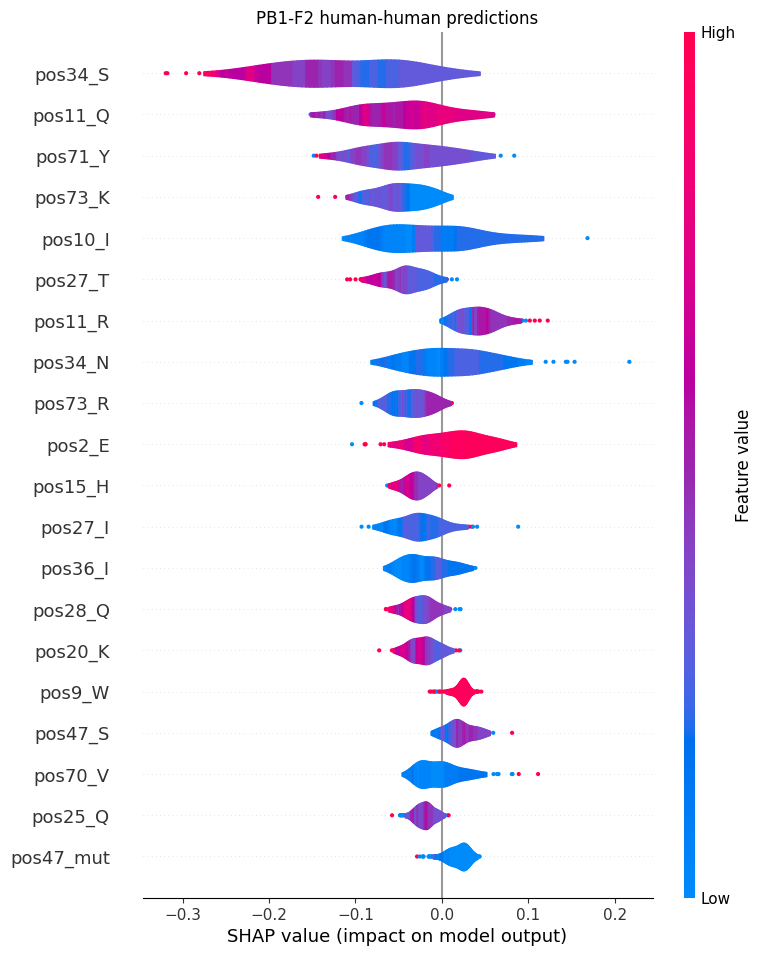

In [12]:
import shap
import matplotlib.pyplot as plt

# Create the SHAP summary plot and store it in a variable
shap.summary_plot(avg_shap[0], X_test, plot_type="violin", show=False)
plt.title("PB1-F2 human-human predictions")
# print plot to file
plt.savefig('PB1-F2_shap_human-human.png', dpi=300, bbox_inches='tight')

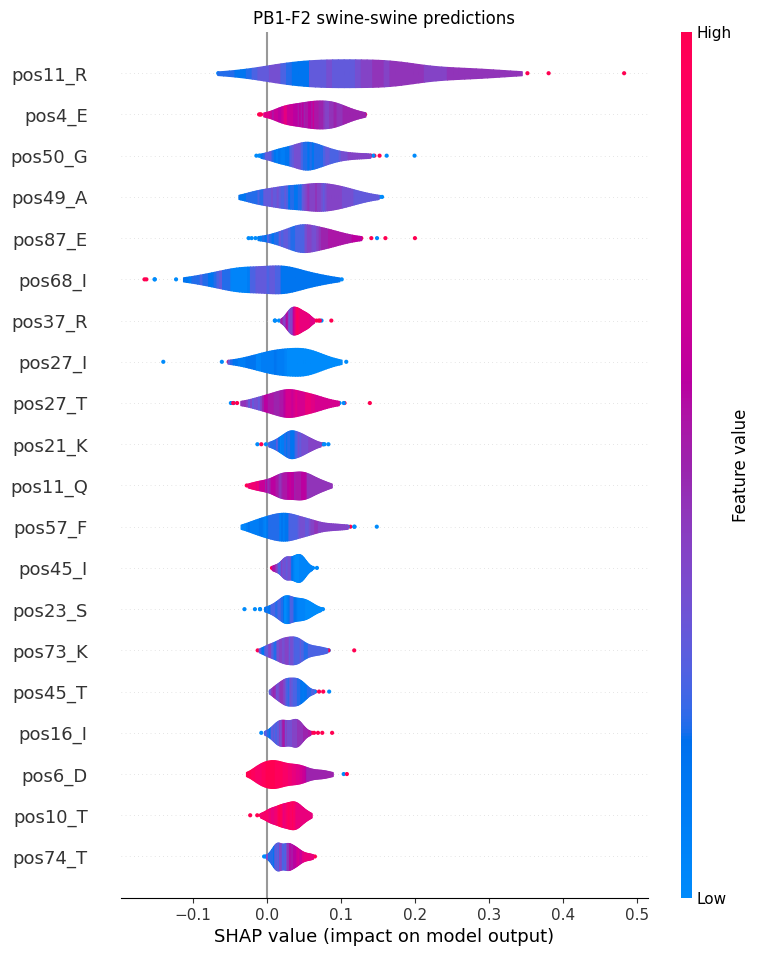

In [13]:
import shap
import matplotlib.pyplot as plt

# Create the SHAP summary plot and store it in a variable
shap.summary_plot(avg_shap[1], X_test, plot_type="violin", show=False)
plt.title("PB1-F2 swine-swine predictions")
# print plot to file
plt.savefig('PB1-F2_shap_swine-swine.png', dpi=300, bbox_inches='tight')

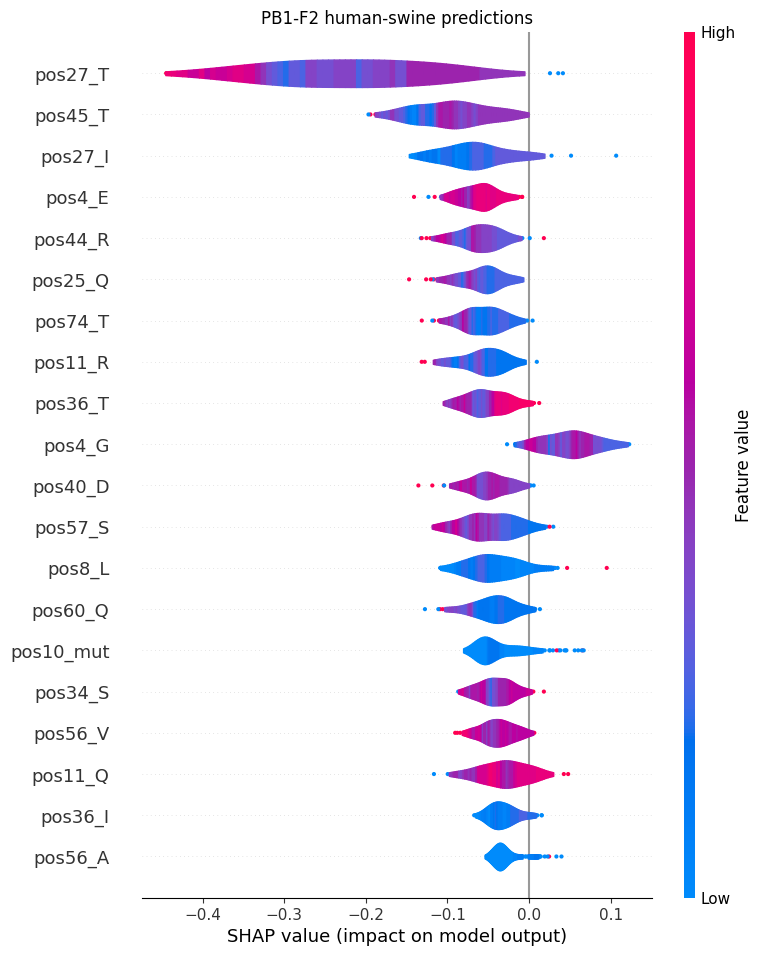

In [14]:
import shap
import matplotlib.pyplot as plt

# Create the SHAP summary plot and store it in a variable
shap.summary_plot(avg_shap[2], X_test, plot_type="violin", show=False)
plt.title("PB1-F2 human-swine predictions")
# print plot to file
plt.savefig('PB1-F2_shap_human-swine.png', dpi=300, bbox_inches='tight')

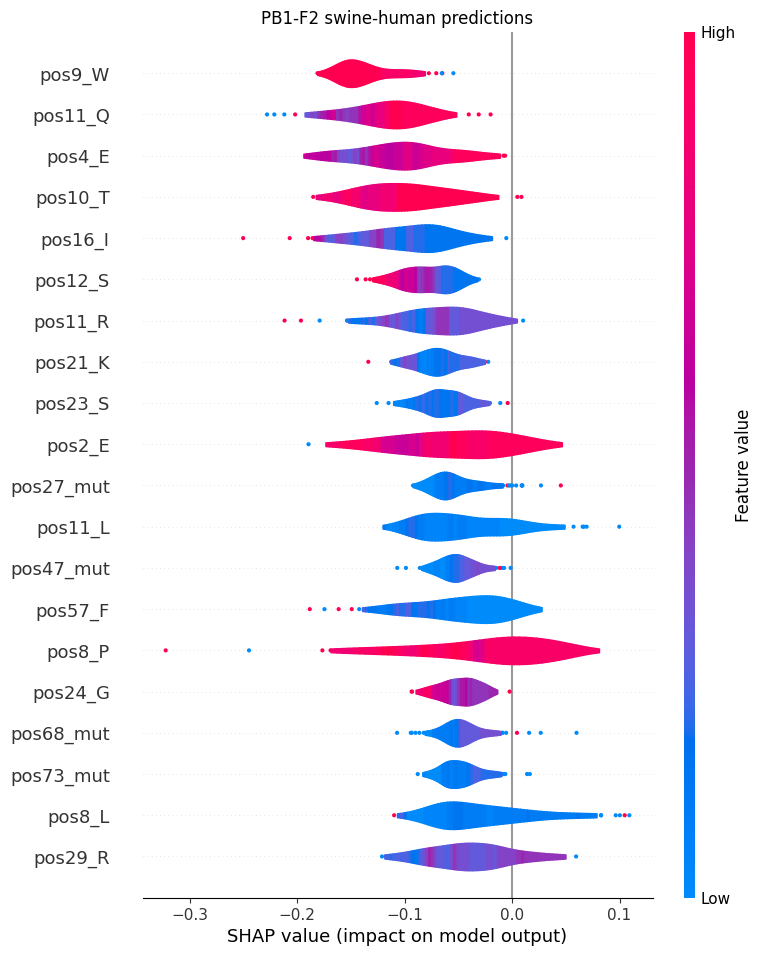

In [15]:
import shap
import matplotlib.pyplot as plt

# Create the SHAP summary plot and store it in a variable
shap.summary_plot(avg_shap[3], X_test, plot_type="violin", show=False)
plt.title("PB1-F2 swine-human predictions")
# print plot to file
plt.savefig('PB1-F2_shap_swine-human.png', dpi=300, bbox_inches='tight')